In [1]:
from transpile_benchy.interfaces.qasm_interface import QASMBench, RedQueen
from transpile_benchy.interfaces.abc_interface import MQTBench
from transpile_benchy.metrics.depth_metric import DepthMetric, TotalMetric
from qiskit.circuit.library import iSwapGate
from qiskit.transpiler import CouplingMap
from mirror_gates.pass_managers import SabreMS, QiskitLevel3
from mirror_gates.utilities import SubsMetric

small -line
small -square
medium - square
medium - hh


In [2]:
# N = 8
# coupling_map = CouplingMap.from_line(N)
# # coupling_map = CouplingMap.from_heavy_hex(3)
# filter_list = ["fredkin", "toffoli", "adder_n4"]
# qasm_bench_m = QASMBench(size="small", filter_list=filter_list)
# filter_list = [
#     "\\bqaoa",
#     "qft",
#     "shor",
#     "dj",
#     "ae",
#     "qgan",
#     "qpeexact",
# ]  # , "grover-v-chain"]
# mqt_bench = MQTBench(num_qubits=N, filter_list=filter_list)

In [3]:
# [print(x) for x in str(qasm_bench_m).split(',')]
# [print(x) for x in str(mqt_bench).split(',')]

In [4]:
# coupling_map = CouplingMap.from_grid(5, 5)
coupling_map = CouplingMap.from_heavy_hex(5)
filter_list = None
qasm_bench_m = QASMBench(size="medium", filter_list=filter_list)
# filter_list = ["\\bqaoa", "qft", "shor", "dj", "ae", "qgan", "qpe"]
filter_list = ["None"]
mqt_bench = MQTBench(num_qubits=24, filter_list=filter_list)

In [5]:
# from qiskit.circuit.library import CXGate, iSwapGate
# from qiskit.extensions import UnitaryGate
# from weylchamber import canonical_gate
# from transpile_benchy.interfaces.qiskit_interface import QiskitFunctionInterface
# from qiskit.circuit.library import TwoLocal

# num_qubits = 8
# coupling_map = CouplingMap.from_line(num_qubits)
# # coupling_map = CouplingMap.from_grid(3, 3)


# def create_TwoLocal_function(
#     entanglement_blocks, entanglement_name, entanglement_type="full", reps=2
# ):
#     """Generates a function to create a TwoLocal object with given parameters"""

#     def TwoLocal_function(n_qubits):
#         return TwoLocal(n_qubits, "ry", entanglement_blocks, entanglement_type, reps)

#     TwoLocal_function.__name__ = (
#         # f"TwoLocal_{entanglement_type}_{entanglement_name}_{reps}reps"
#         f"TwoLocal-{entanglement_name}"
#     )
#     return TwoLocal_function


# def generate_interface_from_data(data, qubits_options):
#     """Generates a QiskitFunctionInterface from gate data and qubits options"""
#     gate, name = data
#     func = create_TwoLocal_function(gate, name)
#     return QiskitFunctionInterface(func, qubits_options)


# num_qubits_options = [num_qubits]  # Or any other options you'd like

# # Specify the gate blocks and their names
# entanglement_blocks_data = [
#     (CXGate(), r"$\texttt{CNOT}$"),
#     # (CXGate().power(1 / 2), r"$\sqrt{\texttt{CNOT}}$"),
#     (iSwapGate(), r"$\texttt{iSWAP}$"),
#     (iSwapGate().power(1 / 2), r"$\sqrt{\texttt{iSWAP}}$"),
#     (UnitaryGate(canonical_gate(0.5, 0.25, 0.25).full()), r"$\texttt{ECP}$"),
# ]

# qiskit_functions_twolocal = [
#     generate_interface_from_data(data, num_qubits_options)
#     for data in entanglement_blocks_data
# ]

In [6]:
# # 5Q backend = provider.backend.ibmq_quito
# # 20Q backend = provider.backend.ibmq_mumbai
# from typing import Callable, List
# from transpile_benchy.interfaces.qiskit_interface import QiskitFunctionInterface

# N = 5
# num_qubits = [N]  # , 20, 24, 28, 32, 36]
# from qiskit.circuit.library import QFT, QuantumVolume

# coupling_map = CouplingMap.from_line(N)
# coupling_map = CouplingMap.from_heavy_hex(5)
# qiskit_functions_qft = [QiskitFunctionInterface(QFT, num_qubits)]
# qiskit_functions_qv = [QiskitFunctionInterface(QuantumVolume, num_qubits)]

In [7]:
import logging

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)
# transpile_benchy_logger.setLevel(logging.WARNING)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

In [8]:
metrics = [DepthMetric(), TotalMetric(), SubsMetric()]

transpilers = [
    QiskitLevel3(coupling_map, cx_basis=True),
    SabreMS(coupling_map, cx_basis=True, parallel=True),
    QiskitLevel3(coupling_map),
    SabreMS(coupling_map, logger=transpile_benchy_logger, parallel=True),
]

In [9]:
from transpile_benchy.benchmark import Benchmark

benchmark = Benchmark(
    transpilers=transpilers,
    # submodules=qiskit_functions_twolocal,
    # submodules=qiskit_functions_qft,
    submodules=[qasm_bench_m, mqt_bench],
    metrics=metrics,
    logger=transpile_benchy_logger,
    num_runs=5,
)

benchmark.run()
# print(benchmark)

Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 1.00	 | cx
  0.00% =    0/1    	 | 2.00	 | cx.cx
100.00% =    1/1    	 | 3.00	 | cx.cx.cx


INFO:transpile_benchy:Running benchmarks for circuits...


Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 0.50	 | xx_plus_yy(-1.57080)
 50.00% =    1/2    	 | 1.00	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)
100.00% =    1/1    	 | 1.50	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)


Running circuits for QASMBench:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
# TODO filter add to results tracking, # number of added SWAPs, # of CNS subs
# remove the results if qiskit adds 0 SWAPS (can't be improved)
# reduce to a set of ~8 circuits at ~16Q scale....

In [ ]:
print(benchmark)


Transpiler: Qiskit-$\sqrt{\texttt{iSWAP}}$

  Metric: accepted_subs
  Circuit: bigadder_n18                             Mean result: 0.000                          Trials: [0, 0, 0, 0, 0]
  Circuit: bv_n14                                   Mean result: 0.000                          Trials: [0, 0, 0, 0, 0]
  Circuit: bv_n19                                   Mean result: 0.000                          Trials: [0, 0, 0, 0, 0]
  Circuit: cat_state_n22                            Mean result: 0.000                          Trials: [0, 0, 0, 0, 0]
  Circuit: dnn_n16                                  Mean result: 0.000                          Trials: [0, 0, 0, 0, 0]
  Circuit: ghz_state_n23                            Mean result: 0.000                          Trials: [0, 0, 0, 0, 0]
  Circuit: knn_n25                                  Mean result: 0.000                          Trials: [0, 0, 0, 0, 0]
  Circuit: multiplier_n15                           Mean result: 0.000                     

In [ ]:
benchmark.summary_statistics(metrics[0], transpilers[0], transpilers[1])

{'average_change': 7.732128988027906,
 'best_circuit': 'qft_n18',
 'worst_circuit': 'cat_state_n22',
 'percent_changes': {'multiplier_n15': 9.965639574575619,
  'bigadder_n18': -24.74319776684507,
  'bv_n14': -13.840734435756513,
  'dnn_n16': -17.56212224064616,
  'qram_n20': -25.214186971883308,
  'swap_test_n25': 1.9174726664321209,
  'qf21_n15': -1.2596961020861863,
  'sat_n11': -8.440439816757499,
  'knn_n25': 11.985933213991139,
  'cat_state_n22': 176.19047619047612,
  'qec9xz_n17': -22.983835249516545,
  'multiply_n13': -19.495264975552296,
  'seca_n11': -12.999970367873448,
  'qft_n18': -39.99068889375109,
  'ghz_state_n23': 113.63636363636358,
  'bv_n19': -3.451684652723968}}

In [ ]:
benchmark.summary_statistics(metrics[0], transpilers[2], transpilers[3])

{'average_change': -3.9372242056941276,
 'best_circuit': 'qft_n18',
 'worst_circuit': 'cat_state_n22',
 'percent_changes': {'multiplier_n15': -2.764168218497159,
  'bigadder_n18': -25.81936974677378,
  'bv_n14': -16.782410670197375,
  'dnn_n16': -16.407491775462972,
  'qram_n20': -4.75351473202407,
  'swap_test_n25': -3.740535109606323,
  'qf21_n15': -2.393962969670792,
  'sat_n11': -8.051387265173885,
  'knn_n25': -0.5641354917686127,
  'cat_state_n22': 78.57142857142857,
  'qec9xz_n17': -28.49375738561053,
  'multiply_n13': -16.08129736266906,
  'seca_n11': -25.535813214288815,
  'qft_n18': -43.583194337280005,
  'ghz_state_n23': 54.545454545454554,
  'bv_n19': -1.1414321289657725}}

In [ ]:
benchmark.summary_statistics(metrics[0], transpilers[2], transpilers[3])

{'average_change': -3.9372242056941276,
 'best_circuit': 'qft_n18',
 'worst_circuit': 'cat_state_n22',
 'percent_changes': {'multiplier_n15': -2.764168218497159,
  'bigadder_n18': -25.81936974677378,
  'bv_n14': -16.782410670197375,
  'dnn_n16': -16.407491775462972,
  'qram_n20': -4.75351473202407,
  'swap_test_n25': -3.740535109606323,
  'qf21_n15': -2.393962969670792,
  'sat_n11': -8.051387265173885,
  'knn_n25': -0.5641354917686127,
  'cat_state_n22': 78.57142857142857,
  'qec9xz_n17': -28.49375738561053,
  'multiply_n13': -16.08129736266906,
  'seca_n11': -25.535813214288815,
  'qft_n18': -43.583194337280005,
  'ghz_state_n23': 54.545454545454554,
  'bv_n19': -1.1414321289657725}}

In [ ]:
benchmark.summary_statistics(metrics[1], transpilers[2], transpilers[3])

{'average_change': 16.377749463659335,
 'best_circuit': 'qft_n18',
 'worst_circuit': 'cat_state_n22',
 'percent_changes': {'multiplier_n15': -0.46817218333662924,
  'bigadder_n18': -12.813382912522172,
  'bv_n14': 84.36819872602254,
  'dnn_n16': 0.0,
  'qram_n20': -0.25309880918255634,
  'swap_test_n25': 5.646808941634545,
  'qf21_n15': 3.754494746244715,
  'sat_n11': -7.217313180515607,
  'knn_n25': 8.093771603126228,
  'cat_state_n22': 85.71428571428568,
  'qec9xz_n17': 2.0834191903370654,
  'multiply_n13': 3.2233952928027194,
  'seca_n11': -5.93560091728873,
  'qft_n18': -24.313024621726097,
  'ghz_state_n23': 75.00000000000007,
  'bv_n19': 45.16020982866764}}

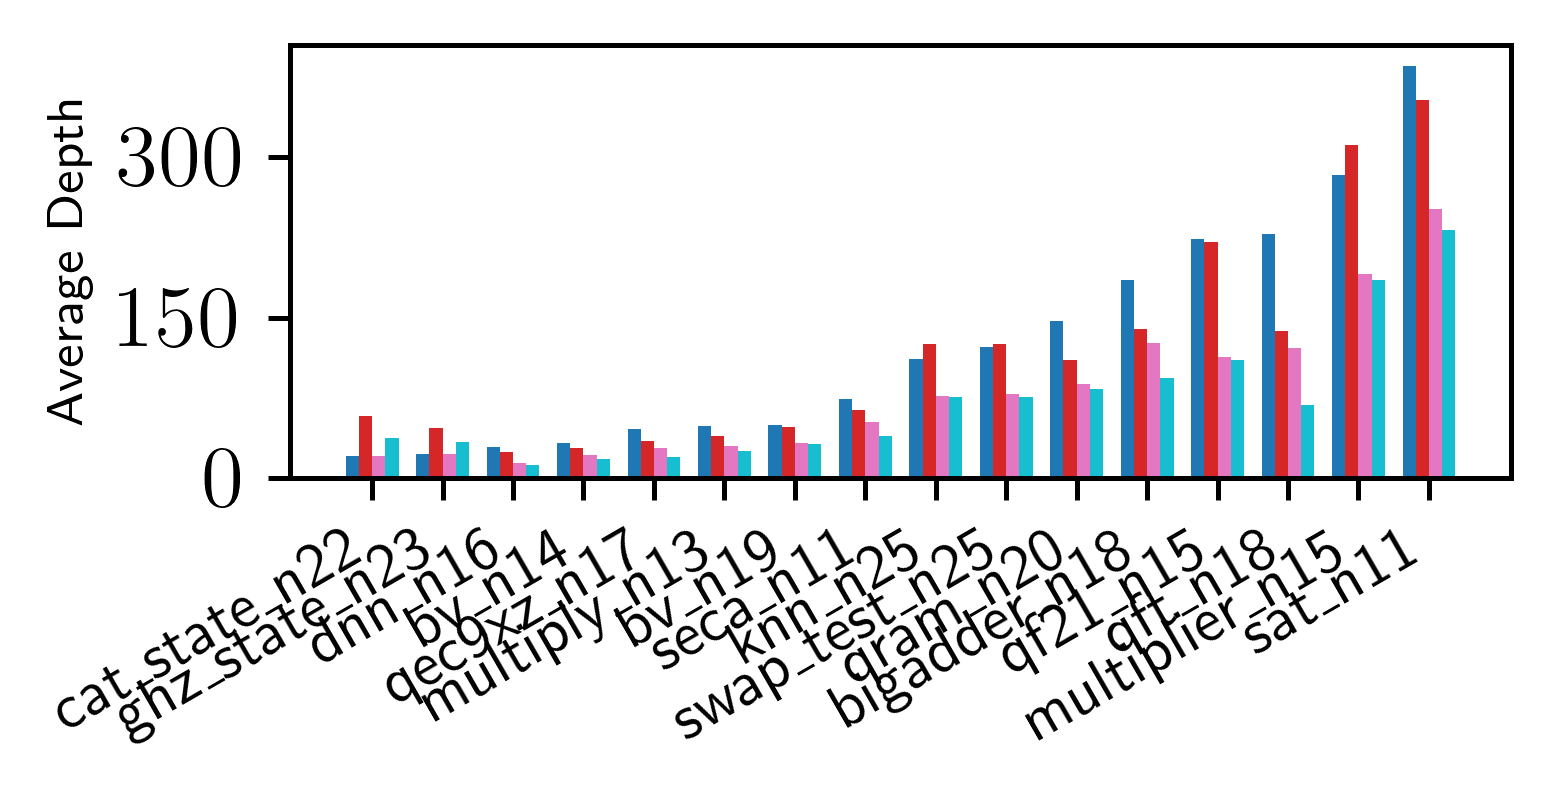

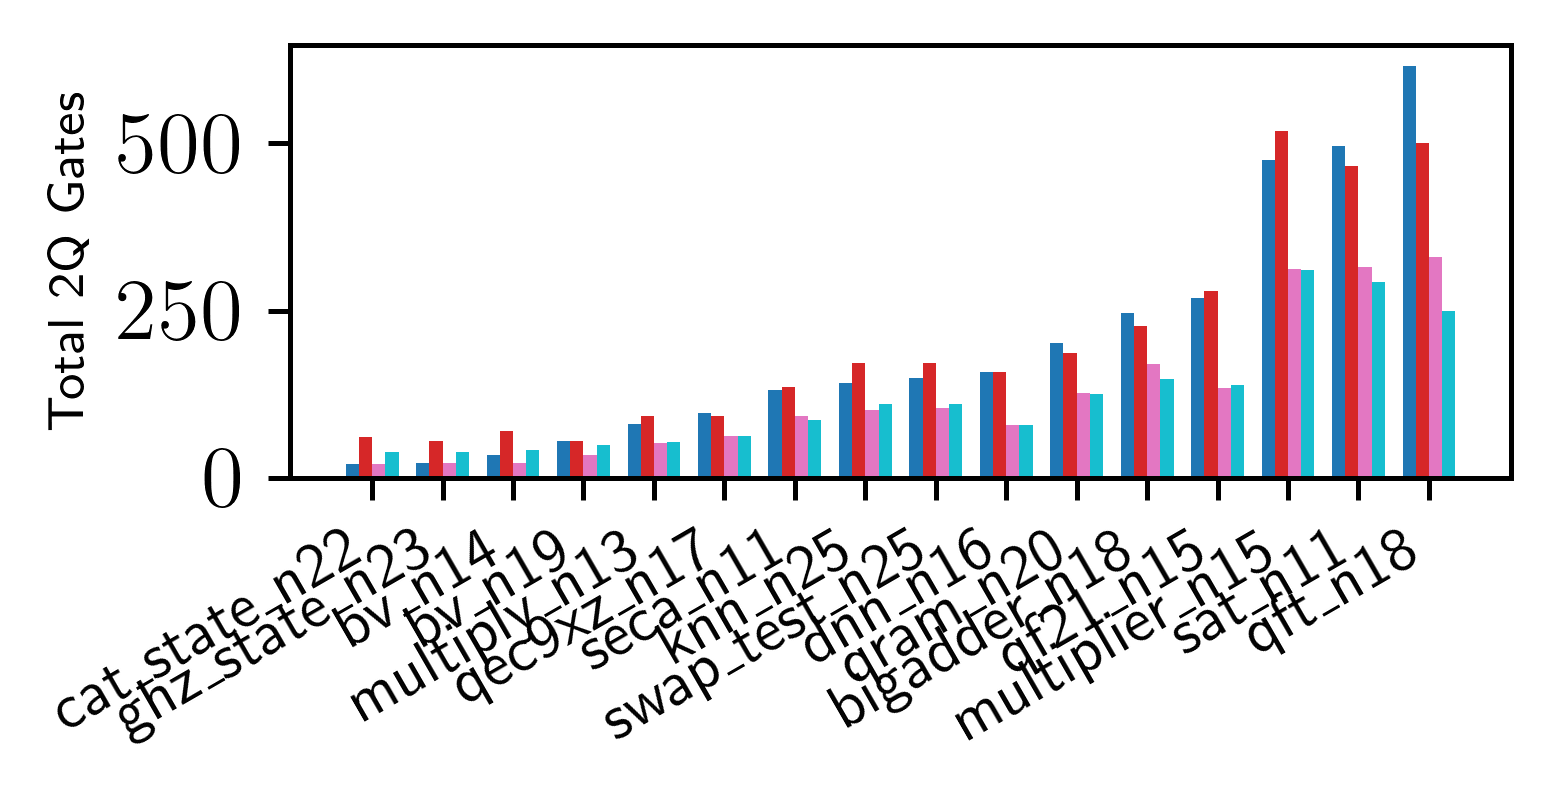

In [ ]:
from transpile_benchy.render import plot_benchmark

plot_benchmark(benchmark, save=1, legend_show=0)

In [ ]:
# from the literature
# toffoli
# fredkin
# EC codes
# Controlled phase
# QAOA
# Controlled phsae
# full entanling
# entanglemnt purification

# linaer, 2d, heavy-hex

# grover
# vqe
# bv
# qft
# qpe
# adder
# multipler
# sqn
# rd84
# co14
# sym9
# hub18
# shor26
# qaoa12
# tfim64
# tfxy64
# toffoli
# fredkin
# adder
# qec_sm
# qec_en
# variational
# hs4
# shor
# pea
# error_correctiond3
# simons
# qaoa
# hhl
# dnn
# qpe
# ising

In [ ]:
# benchmarks from NASSC
# from Qiskit, QASMBench, RevLib
# grover_n4
# grover_n6
# grover_n8
# vqe_n8
# vqe_n12
# bv_n19
# qft_n15
# qft_20
# qpe_n9
# adder_n10
# multiplier_n25
# sqn_n258 (?)
# rd84_n253
# co14_n215
# sym9_n193

In [ ]:
# benchmarks from PAS+PAM
# from qiskit, supermarq (qaoa)
# adder63
# mul60
# qft5
# qft64
# grover5
# hub18
# shor26
# qaoa12
# tfim64
# tfxy64